In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import einops
from einops import rearrange, reduce

In [3]:
import torch.nn.functional as F

In [4]:
from tqdm import tqdm, trange

In [5]:
data_path = '/home/roger/1D_diffusion/data/OCPLearn/data/loosedbfile_resolve.npz'

In [6]:
ds_file = np.load(data_path)

In [7]:
sample_data = ds_file['Sol'][0]

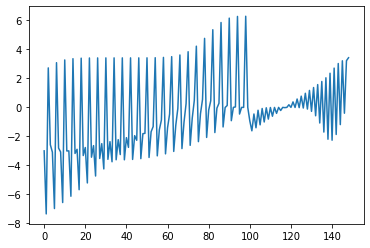

In [8]:
plt.plot(sample_data)

In [9]:
# Define used models
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from diffusion.conditional_unet1d import ConditionalUnet1D
from diffusion.normalizer import LinearNormalizer

traj_dim = 1

In [10]:
model = ConditionalUnet1D(
    input_dim=traj_dim
)

In [11]:
# Test
timestep = torch.tensor(0)
sample = torch.zeros((1, 148, 1))

In [12]:
out = model(sample, timestep)

In [13]:
# Define hyperparameters

In [14]:
# Beta scheduler is important
my_noise_scheduler = DDIMScheduler(
    num_train_timesteps=100,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=True,
    set_alpha_to_one=True,
    steps_offset=0,
    prediction_type='epsilon', # or directly predict sample
)

batch_size = 64
train_iters = 10000
init_lr = 1e-3

In [15]:
model = model.cuda()

In [16]:
# Normalizer
my_normalizer = LinearNormalizer()

In [17]:
train_traj = ds_file['Sol'][0].reshape((1, -1, 1))
train_traj = train_traj[:,:-1,:]  # truncate to even number
train_traj = torch.tensor(train_traj)
train_traj = train_traj.repeat((batch_size, 1, 1))
train_traj = train_traj.cuda().float()
train_traj.shape

torch.Size([64, 148, 1])

In [18]:
my_normalizer.fit(data=train_traj, last_n_dims=1)

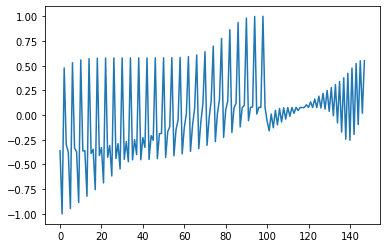

In [19]:
plt.plot(my_normalizer.normalize(train_traj)[0,:,0].cpu().numpy())

In [20]:
# Pre training loop

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=0.9)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, train_iters)

In [22]:
# Training loop

In [23]:
running_loss = 0.

for train_iter_idx in trange(train_iters):
    noise = torch.randn(train_traj.shape, device=train_traj.device)

    timesteps = torch.randint(
        0, my_noise_scheduler.config.num_train_timesteps, 
        (batch_size,), device=train_traj.device
    ).long()

    noisy_trajectory = my_noise_scheduler.add_noise(train_traj, noise, timesteps)
    
    optimizer.zero_grad()

    # TODO: add conditioning
    pred = model(noisy_trajectory, timesteps, local_cond=None, global_cond=None)

    pred_type = my_noise_scheduler.config.prediction_type 
    if pred_type == 'epsilon':
        target = noise
    elif pred_type == 'sample':
        target = train_traj
    else:
        raise ValueError(f"Unsupported prediction type {pred_type}")

    loss = F.mse_loss(pred, target, reduction='none')
    loss = reduce(loss, 'b ... -> b (...)', 'mean')
    loss = loss.mean()
    
    loss.backward()
    optimizer.step()
#     scheduler.step()
    running_loss += loss.item()
    
    if train_iter_idx % 500 == 499:
        print("Running training loss: {:.4f}".format(running_loss / 500))
        running_loss = 0

  5%|▌         | 502/10000 [00:24<07:43, 20.48it/s]

Running training loss: 0.1301


 10%|█         | 1003/10000 [00:50<07:41, 19.49it/s]

Running training loss: 0.0508


 15%|█▌        | 1502/10000 [01:17<07:50, 18.07it/s]

Running training loss: 0.0384


 20%|██        | 2002/10000 [01:43<07:00, 19.04it/s]

Running training loss: 0.0317


 25%|██▌       | 2502/10000 [02:10<06:32, 19.08it/s]

Running training loss: 0.0293


 30%|███       | 3003/10000 [02:37<05:53, 19.80it/s]

Running training loss: 0.0260


 35%|███▌      | 3503/10000 [03:02<05:31, 19.60it/s]

Running training loss: 0.0233


 40%|████      | 4003/10000 [03:28<06:09, 16.24it/s]

Running training loss: 0.0213


 45%|████▌     | 4503/10000 [03:55<04:34, 20.00it/s]

Running training loss: 0.0201


 50%|█████     | 5003/10000 [04:20<04:18, 19.34it/s]

Running training loss: 0.0187


 55%|█████▌    | 5503/10000 [04:46<03:48, 19.65it/s]

Running training loss: 0.0168


 60%|██████    | 6003/10000 [05:12<03:23, 19.63it/s]

Running training loss: 0.0157


 65%|██████▌   | 6503/10000 [05:37<02:57, 19.67it/s]

Running training loss: 0.0158


 70%|███████   | 7003/10000 [06:02<02:32, 19.67it/s]

Running training loss: 0.0148


 75%|███████▌  | 7503/10000 [06:28<02:06, 19.69it/s]

Running training loss: 0.0125


 80%|████████  | 8003/10000 [06:54<01:45, 18.99it/s]

Running training loss: 0.0128


 85%|████████▌ | 8503/10000 [07:19<01:17, 19.22it/s]

Running training loss: 0.0107


 90%|█████████ | 9003/10000 [07:45<00:51, 19.48it/s]

Running training loss: 0.0108


 95%|█████████▌| 9503/10000 [08:11<00:25, 19.56it/s]

Running training loss: 0.0111


100%|██████████| 10000/10000 [08:36<00:00, 19.35it/s]

Running training loss: 0.0105


In [24]:
# Visualize training sample from last training iter

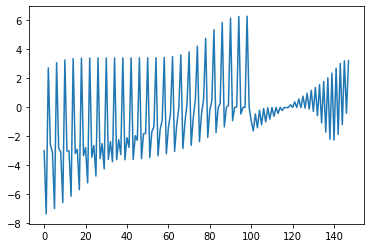

In [25]:
plt.plot(train_traj[0,:,0].detach().cpu().numpy())

In [26]:
print(timesteps)

tensor([70, 47, 85, 53, 75, 60, 97, 59, 76, 58, 44, 64, 93, 71, 62, 75, 25, 51,
        30, 85, 82, 68, 99, 75, 24, 85, 94, 15, 67, 99, 76, 52, 21,  6, 10, 30,
        57,  7, 75, 23, 52, 69, 59, 89, 85, 65, 83,  6,  2, 44, 81, 90, 49,  4,
         1,  8, 65, 65, 59, 25, 97, 65, 95, 77], device='cuda:0')


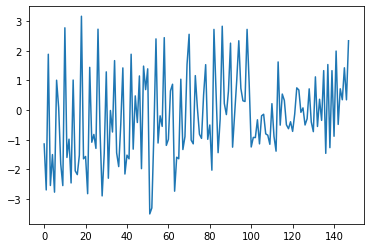

In [27]:
plt.plot(noisy_trajectory[0,:,0].detach().cpu().numpy())

In [28]:
# Test model

In [29]:
model.eval()

generated_trajectory = torch.randn(
    size=(1,) + train_traj.shape[1:], 
    dtype=train_traj.dtype,
    device=train_traj.device)

In [30]:
# TODO: user DDIM sampling to accelerate generation
my_noise_scheduler.set_timesteps(my_noise_scheduler.config.num_train_timesteps)

In [31]:
generated_traj_list = []

In [32]:
with torch.no_grad():
    for t in tqdm(my_noise_scheduler.timesteps):
        # 2. predict model output
        model_output = model(generated_trajectory, t, 
            local_cond=None, global_cond=None)

        # 3. compute previous image: x_t -> x_t-1
        generated_trajectory = my_noise_scheduler.step(
            model_output, t, generated_trajectory, 
            ).prev_sample
        
        generated_traj_list.append(generated_trajectory)

100%|██████████| 100/100 [00:00<00:00, 201.08it/s]


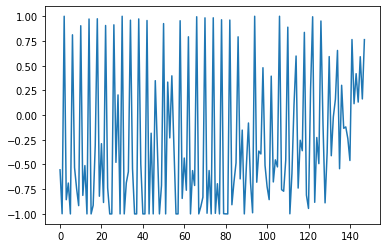

In [33]:
plt.plot(generated_trajectory[0,:,0].detach().cpu().numpy())

In [34]:
real_generated_traj = my_normalizer.unnormalize(generated_trajectory)

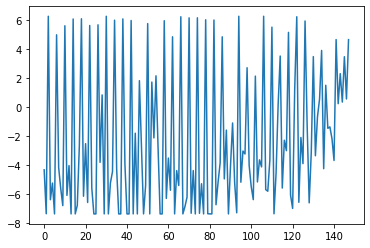

In [35]:
plt.plot(real_generated_traj[0,:,0].detach().cpu().numpy())

In [36]:
len(generated_traj_list)

100

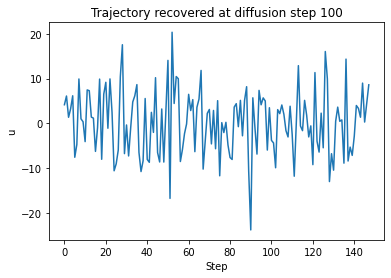

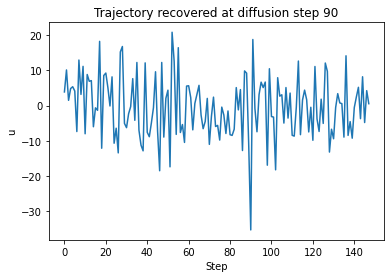

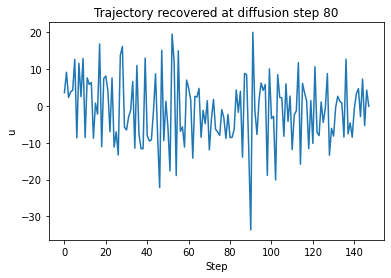

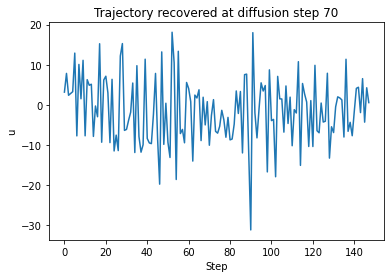

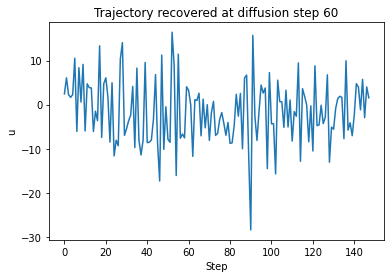

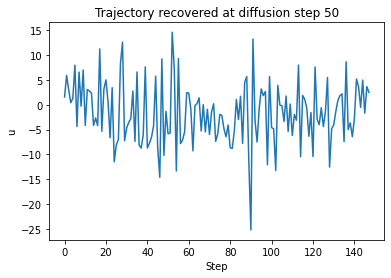

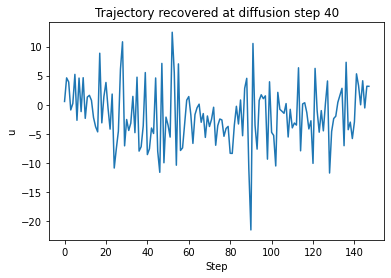

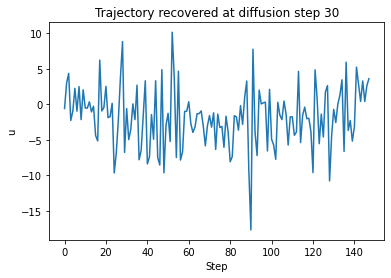

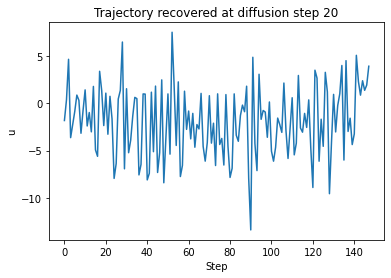

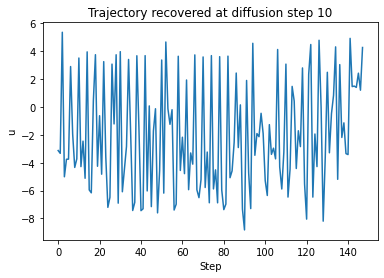

In [37]:
for i in range(0, 100, 10):
    plt.figure()
    all_traj = generated_traj_list[i]
    real_traj = my_normalizer.unnormalize(all_traj)
    plt.plot(real_traj[0,:,0].detach().cpu().numpy())
    plt.xlabel("Step")
    plt.ylabel("u")
    plt.title(f"Trajectory recovered at diffusion step {100 - i}")